# Diffraction pattern of a hydrated molecule
We have implemented a grid/mask approach to account for the contribution of a hydration layer.

First, a cubic mesh centered on the protein is built. Its dimensions are determined by the maximum dimension of the protein to which 2 layers of user-defined thickness are added. The number of voxels per side is determined by the user-defined voxel size. 
Then, two masks (solute and solvent) are built. The solute mask is built in two steps. The first step initializes the mask by defining each voxel containing at least one protein atom as part of the mask, and all others as outside the mask. The mask is then “closed” (dilation followed by an erosion) by a sphere and dilated one final time by the same sphere. The radius of the spheres is set to 3.5 Å. An inflated mask is built following the same approach, this time with a sphere radius increased by one user-defined layer thickness; the hydration layer (or solvent) mask is then deduced as the region inside the inflated mask, but outside the solute mask. 

The solvent form factor is then computed as the Fourier transform of the hydration layer mask, assuming constant electron density (typically set at 0.334 electrons per cubic Å for water). The Fourier transform is carried by summing over all grid points within the layer, in a GPU-optimized manner following the approach followed for the solute atoms. It is then added to the solute form factor to generate the diffraction pattern.

In [36]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skopi as sk

## Inputs and parameters

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/2cex.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

## Definition of the beam, the detector and the hydrated particle

### Beam
We illustrate below how to define the beam, retrieve its flux and change it eventually

In [4]:
beam = sk.Beam(beamfile)

In [5]:
increase_factor = 1e2
print('BEFORE: # of photons per pulse {}'.format(beam.get_photons_per_pulse()))
print('>>> Increasing the number of photons per pulse by a factor {}'.format(increase_factor))
beam.set_photons_per_pulse(increase_factor * beam.get_photons_per_pulse())
print('AFTER : # of photons per pulse {}'.format(beam.get_photons_per_pulse()))

BEFORE: # of photons per pulse 1e+12
>>> Increasing the number of photons per pulse by a factor 100.0
AFTER : # of photons per pulse 1e+14


### Detector
We illustrate below how to define the detector, and change its distance to the sample

In [6]:
det = sk.PnccdDetector(geom=geom, beam=beam)

In [7]:
increase_factor = 0.5
print('BEFORE: Detector distance {} m'.format(det.distance))
print('>>> Increasing the distance by a factor {}'.format(increase_factor))
det.distance = increase_factor * det.distance
print('AFTER : Detector distance {} m'.format(det.distance))

BEFORE: Detector distance 0.581 m
>>> Increasing the distance by a factor 0.5
AFTER : Detector distance 0.2905 m


### Particle
We illustrate below how to build a particle from a PDB file and then hydrate it

In [8]:
particle = sk.Particle()
particle.read_pdb(pdbfile, ff='WK')
print('Number of atoms in particle: {}'.format(particle.get_num_atoms()))

('Unknown element or wrong line: \n', 'HETATM 2364 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
no symmetry REMARK 350 found
Number of atoms in particle: 2451


In [9]:
hydration_layer_thickness = 6.0 / 10**10
mesh_voxel_size           = 2.0 / 10**10
print('Hydration layer: [ {} m (thickness) ] [ {} m (mesh voxel size) ]'.format(hydration_layer_thickness,mesh_voxel_size))

Hydration layer: [ 6e-10 m (thickness) ] [ 2e-10 m (mesh voxel size) ]


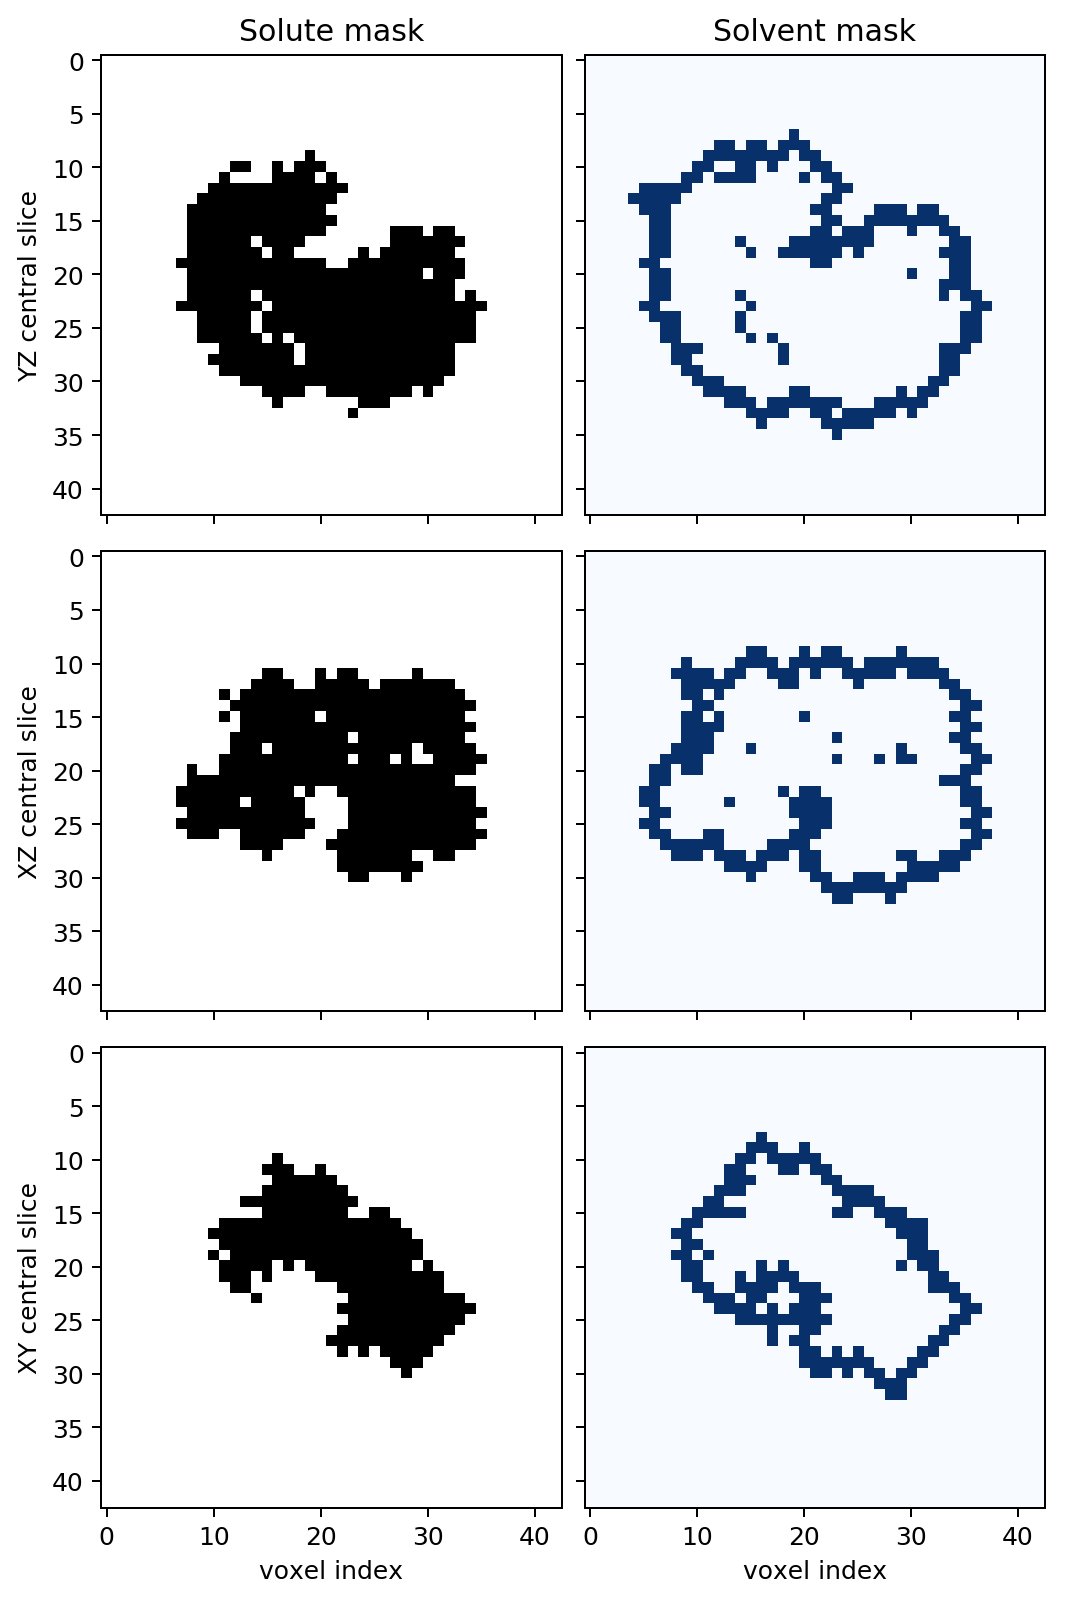

In [10]:
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.create_masks()
particle.show_masks()

## perform SPI Experiment
Let's generate a diffraction pattern of the hydrated object and visualize it

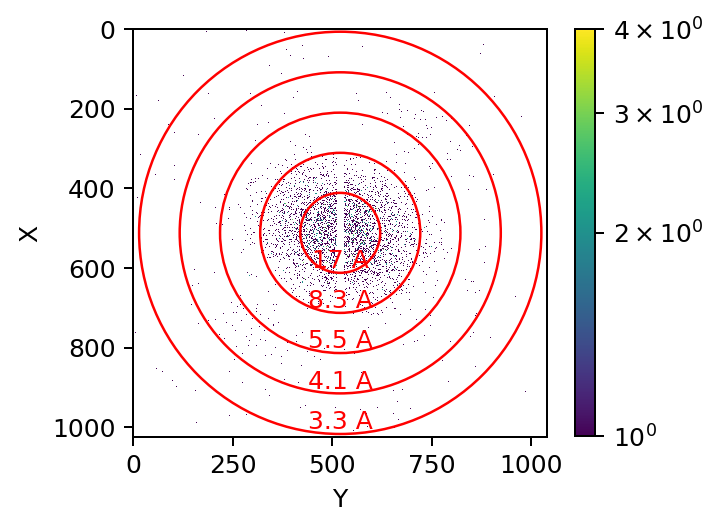

In [34]:
experiment = sk.SPIExperiment(det, beam, particle)
image = experiment.generate_image()
#
fig = plt.figure(figsize=(4,3), dpi=180)
viz = sk.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
viz.imshow(image)

To get a better idea of the effect of the hydration layer, let's fix the orientation of the diffraction pattern, and generate for 3 different hydration layers:

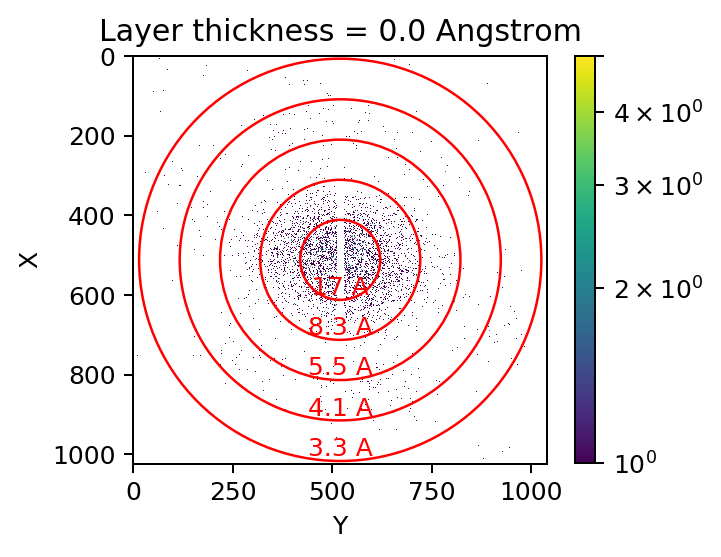

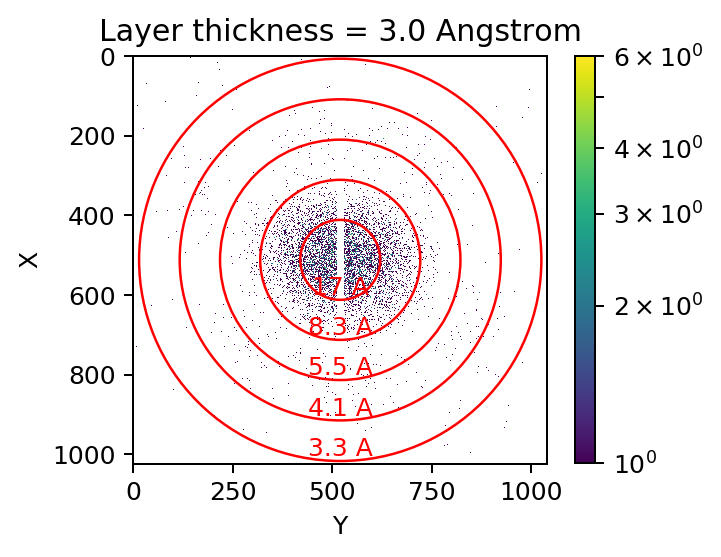

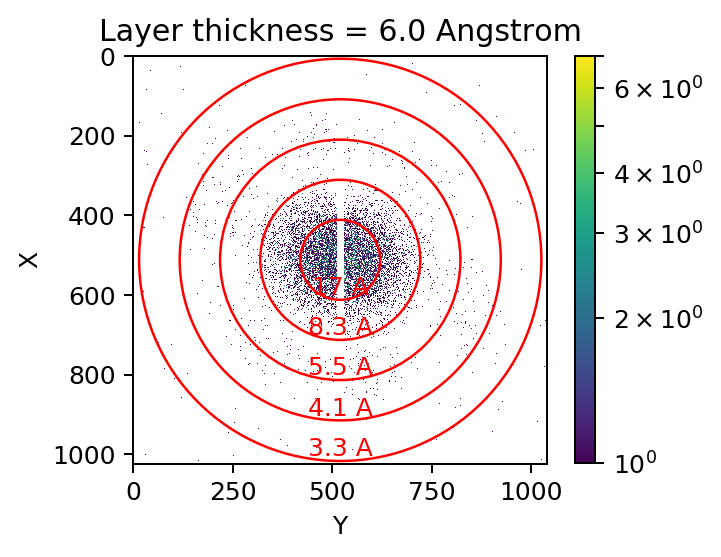

In [35]:
orientation = None 
for thickness in [0., 3., 6.]:
    hydration_layer_thickness = thickness / 10**10
    mesh_voxel_size           = 2.0 / 10**10
    particle.set_hydration_layer_thickness(hydration_layer_thickness)
    particle.create_masks()
    experiment = sk.SPIExperiment(det, beam, particle, orientations=orientation)
    if orientation is None:
        image, orientation = experiment.generate_image(return_orientation=True)
    else:
        image = experiment.generate_image()
    viz = sk.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    fig = plt.figure(figsize=(4,3), dpi=180)
    plt.title('Layer thickness = {} Angstrom'.format(thickness))
    viz.imshow(image)

## Illustrate with SAXS profile
Below we compute the radial incoherent sum of `N` particles up to `resmax` resolution, in the case where each particle is hydrated by a layer of given thickness, or not hydrated. We plot the resulting radial profiles below.

In [28]:
N = 1000000           # number of particles
resmax = 2. / 10**10  # max. resolution in meters
#
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.create_masks()
saxs_wet = sk.SAXS(particle, N, resmax)
q_wet, I_wet = saxs_wet.compute()
#
particle.set_hydration_layer_thickness(0.)
particle.create_masks()
saxs_dry = sk.SAXS(particle, N, resmax)
q_dry, I_dry = saxs_dry.compute()

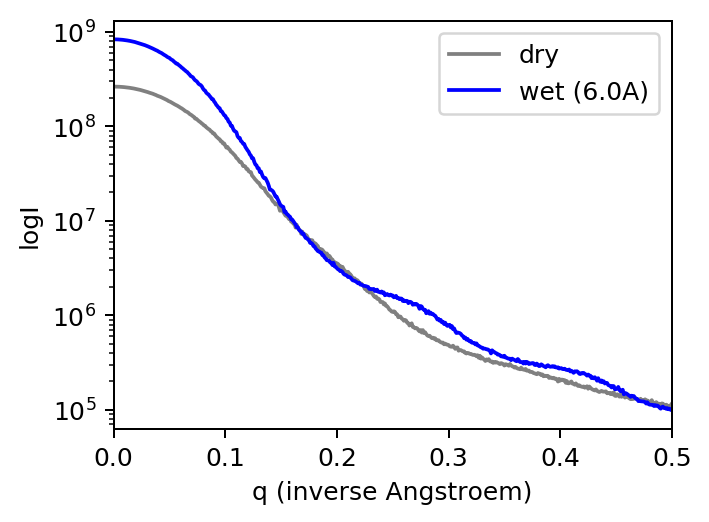

In [33]:
fig = plt.figure(figsize=(4,3),dpi=180)
plt.yscale('log')
plt.xlim(0,q_dry[-1]/10**10)
plt.xlabel('q (inverse Angstroem)')
plt.ylabel('logI')
plt.plot(q_dry/10**10, I_dry, color='grey', label='dry')
plt.plot(q_wet/10**10, I_wet, color='blue', label='wet ({}A)'.format(hydration_layer_thickness*10**10))
plt.legend()
plt.show()